# Investigate results of fitting procedure

In [1]:
import sys
sys.path.append("../python/")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde
import pickle
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM

from matplotlib import rc
rc('font', family='times new roman', size=22.)

### Dependence with relative uncertainty on observed temperature

0.8452422416044016 1.052955241832966


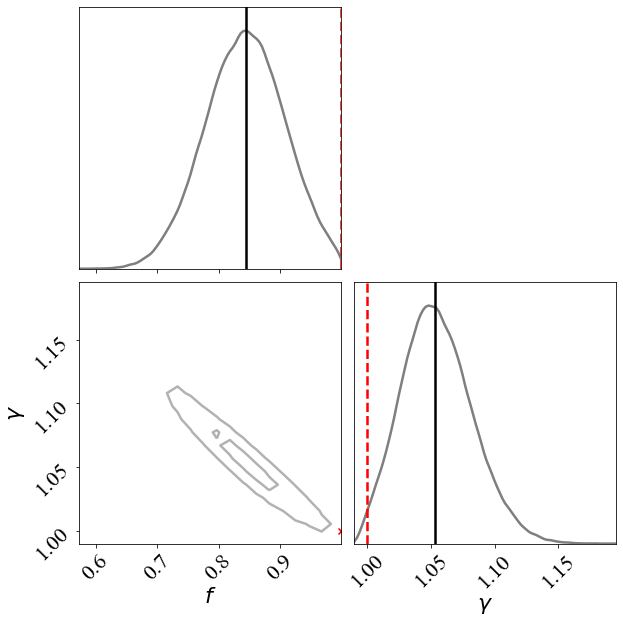

In [18]:
_file   = open("../results/bayesian/likelihood_game0_uncTobs_0.03v97", "rb") 
like    = pickle.load(_file)
_file   = open("../results/bayesian/posterior_game0_uncTobs_0.03v97", "rb") 
samples = pickle.load(_file)

smooth=0.5
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 3], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5, alpha=0.5)

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="-", lw=2.5, color="k")
axes[1, 1].axvline(ML[1], ls="-", lw=2.5, color="k")
axes[0, 0].axvline(1., ls="--", lw=2.5, color="red")
axes[1, 1].axvline(1., ls="--", lw=2.5, color="red")
axes[1, 0].scatter(1., 1., marker="x", color="red")

axes[1, 0].set_ylabel(r"$\gamma$")
axes[1, 0].set_xlabel(r"$f$")
axes[1, 1].set_xlabel(r"$\gamma$")

print(ML[0], ML[1])

In [2]:
rel_unc_Tobs = [0.01, 0.02, 0.03, 0.05, 0.10, 0.25, 0.50]

mean = {}; median = {}; MAP = {}; ML = {};

for rel_unc in rel_unc_Tobs:
    data = np.genfromtxt(("../results/bayesian/statistics_game0_uncTobs_%.2f.dat" %rel_unc), unpack=True)
    mean[rel_unc]   = np.array((data[0], data[1]))
    #print(mean[rel_unc].shape, mean[rel_unc][:, 0], mean[rel_unc][0])
    median[rel_unc] = np.array((data[2], data[3]))
    MAP[rel_unc]    = np.array((data[4], data[5]))
    ML[rel_unc]     = np.array((data[6], data[7]))

In [3]:
f_true        = 1.
gamma_true    = 1.
true          = [f_true, gamma_true]
rank          = mean[rel_unc].shape[1]
D             = mean[rel_unc].shape[0] # dimension parameter space
FSE           = {}
FSE["mean"]   = []
FSE["median"] = []
FSE["MAP"]    = []
FSE["ML"]     = []

for i in range(D):
    FSE["mean"].append([])
    FSE["median"].append([])
    FSE["MAP"].append([])
    FSE["ML"].append([])
    for rel_unc in rel_unc_Tobs:
        FSE["mean"][i].append(np.sqrt(1/rank*np.sum(np.power(mean[rel_unc][i] - true[i], 2)))/true[i])
        FSE["median"][i].append(np.sqrt(1/rank*np.sum(np.power(median[rel_unc][i] - true[i], 2)))/true[i])
        FSE["MAP"][i].append(np.sqrt(1/rank*np.sum(np.power(MAP[rel_unc][i] - true[i], 2)))/true[i])
        FSE["ML"][i].append(np.sqrt(1/rank*np.sum(np.power(ML[rel_unc][i] - true[i], 2)))/true[i])

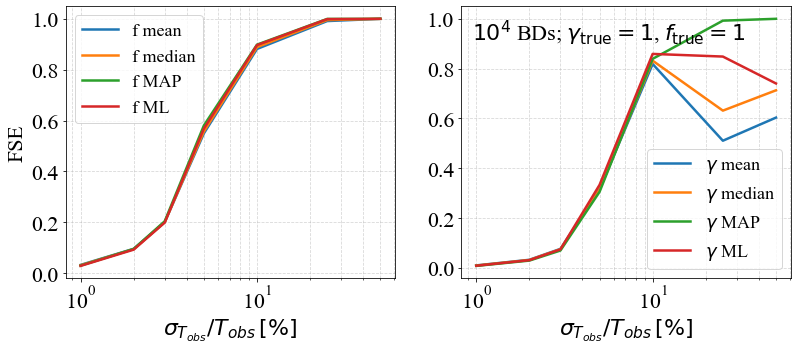

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

rel_unc_Tobs = [1, 2, 3, 5, 10, 25, 50]
labels       = ["mean", "median", "MAP", "ML"]

for k in range(4):
    ax[0].plot(rel_unc_Tobs, FSE[labels[k]][0], label="f " + labels[k], lw=2.5)
    ax[1].plot(rel_unc_Tobs, FSE[labels[k]][1], lw=2.5, label="$\gamma$ " + labels[k],)

ax[0].legend(frameon=True, fontsize=18)
ax[1].legend(frameon=True, loc=4, fontsize=18)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")
ax[1].set_xlabel(r"$\sigma_{T_{obs}}/T_{obs}\, [\%]$")

text_box = AnchoredText(r"$10^4$ BDs; $\gamma_{\rm true}=1$, $f_{\rm true}=1$", frameon=False, loc=2, pad=0.01)
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_nBDs1000_f1_gamma1.pdf", bbox_inches="tight")

**Understand why funny shape FSE for $\gamma$**

Text(0.5, 0, '$\\gamma$')

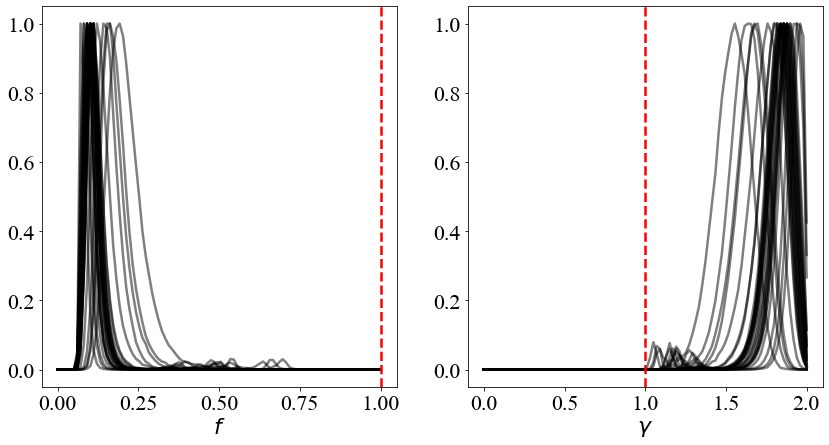

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(30):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.1v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

Text(0.5, 0, '$\\gamma$')

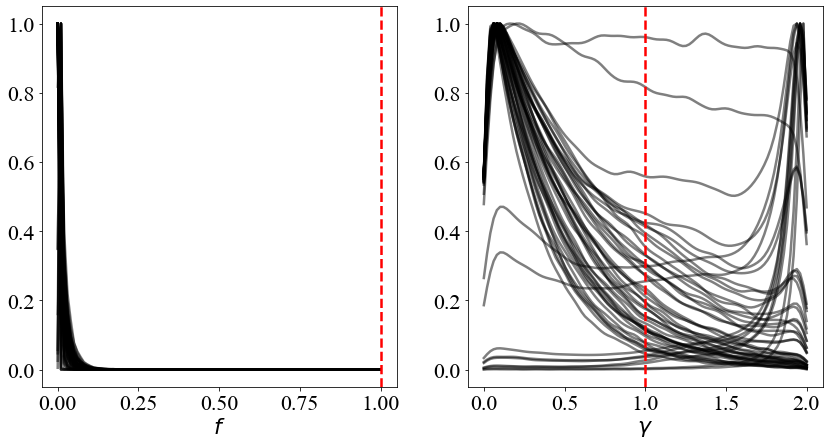

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(50):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.25v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

Text(0.5, 0, '$\\gamma$')

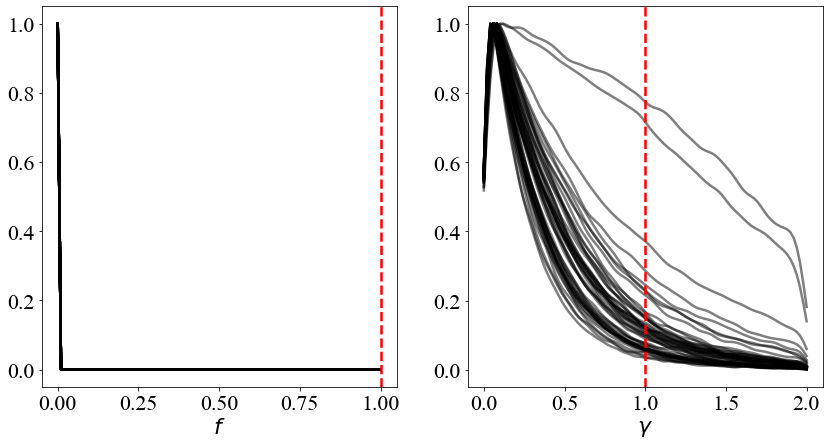

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

xvals0 = np.linspace(0, 1, 100)
xvals1 = np.linspace(0, 2, 100)
    
for i in range(50):
    _file   = open("../results/bayesian/posterior_game0_uncTobs_0.5v" + str(i), "rb") 
    samples = pickle.load(_file)
    kde   = gaussian_kde(samples.T[0])
    ax[0].plot(xvals0, kde(xvals0)/np.max(kde(xvals0)), color="k", lw=2.5, alpha=0.5)
    kde   = gaussian_kde(samples.T[1])
    ax[1].plot(xvals1, kde(xvals1)/np.max(kde(xvals1)), color="k", lw=2.5, alpha=0.5)

ax[0].axvline(1., ls="--", lw=2.5, color="red")
ax[1].axvline(1., ls="--", lw=2.5, color="red")

ax[0].set_xlabel(r"$f$")
ax[1].set_xlabel(r"$\gamma$")

### Dependence with observed number of BDs

In [62]:
nBDs = [1000, 5000, 10000, 20000, 50000]

mean = {}; median = {}; MAP = {}; ML = {};

for n in nBDs:
    if n==10000:
        data = np.genfromtxt(("../results/bayesian/statistics_game0_uncTobs_0.05.dat"), unpack=True)
    else:
        data = np.genfromtxt(("../results/bayesian/statistics_game0_nBDs_%i.dat" %n), unpack=True)
    mean[n]   = np.array((data[0], data[1]))
    median[n] = np.array((data[2], data[3]))
    MAP[n]    = np.array((data[4], data[5]))
    ML[n]     = np.array((data[6], data[7]))

In [63]:
f_true        = 1.
gamma_true    = 1.
true          = [f_true, gamma_true]
rank          = mean[n].shape[1]
D             = mean[n].shape[0] # dimension parameter space
FSE           = {}
FSE["mean"]   = []
FSE["median"] = []
FSE["MAP"]    = []
FSE["ML"]     = []

for i in range(D):
    FSE["mean"].append([])
    FSE["median"].append([])
    FSE["MAP"].append([])
    FSE["ML"].append([])
    for n in nBDs:
        FSE["mean"][i].append(np.sqrt(1/rank*np.sum(np.power(mean[n][i] - true[i], 2)))/true[i])
        FSE["median"][i].append(np.sqrt(1/rank*np.sum(np.power(median[n][i] - true[i], 2)))/true[i])
        FSE["MAP"][i].append(np.sqrt(1/rank*np.sum(np.power(MAP[n][i] - true[i], 2)))/true[i])
        FSE["ML"][i].append(np.sqrt(1/rank*np.sum(np.power(ML[n][i] - true[i], 2)))/true[i])

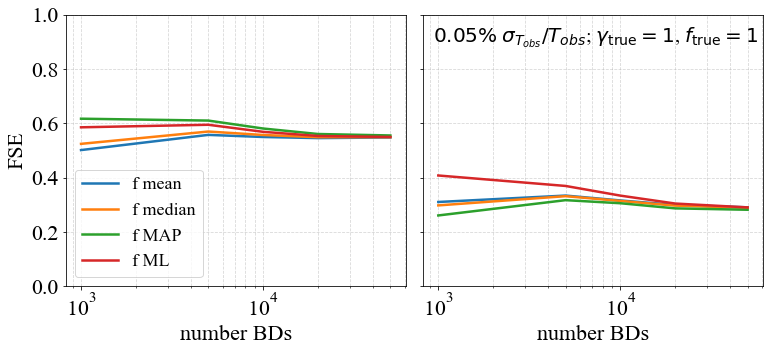

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 5), sharey=True)
plt.subplots_adjust(wspace=0.05)

nBDs   = [1000, 5000, 10000, 20000, 50000]
labels = ["mean", "median", "MAP", "ML"]

for k in range(4):
    ax[0].plot(nBDs, FSE[labels[k]][0], label="f " + labels[k], lw=2.5)
    ax[1].plot(nBDs, FSE[labels[k]][1], lw=2.5, label="$\gamma$ " + labels[k])

ax[0].legend(frameon=True, fontsize=18)
#ax[1].legend(frameon=True)
ax[0].set_ylabel("FSE")
ax[0].set_xlabel("number BDs")
ax[1].set_xlabel("number BDs")

text_box = AnchoredText(r"$0.05\%$ $\sigma_{T_{obs}}/T_{obs}$; $\gamma_{\rm true}=1$, $f_{\rm true}=1$", 
                        frameon=False, loc=2, pad=0.01, prop=dict(size=20))
plt.setp(text_box.patch, facecolor="white")
ax[1].add_artist(text_box)

ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[1].grid(which="both", ls="--", alpha=0.5)

fig.savefig("../Figs/game0_FS1_0.05_f1_gamma1.pdf", bbox_inches="tight")